# Regression

**If you are a Colab user**

If you use Google Colab, you can uncomment the following cell to mount your Google Drive to Colab.
After that, Clab can read/write files and data in your Google Drive

please change the current directory to be the folder that you save your Notebook and
data folder. For example, I save my Colab files and data in the following location

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/Colab\ Notebooks

**Install new library statsmodels**

Using the installation command in the terminal (if your computer is a Linux system) or
other command-line interpreter application like Anaconda Prompt
(if your computer is a Windows system):

*conda install statsmodels*

If you would like to install it from this notebook, you uncomment the following cell and execute it

In [2]:
#!pip3 install statsmodels

**Set up standards for the remainder of the notebook**

In [3]:
## import libraries and tools ##

import numpy as np # linear algebra
import pandas as pd # data processing and CSV file I/O

import scipy as sp # scientific and technical computing
from scipy import stats

import math

#from matplotlib import rcParams
import matplotlib.pyplot as plt # visualization
import seaborn as sns

# we primarily use sklearn in this model
import sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, ElasticNetCV

# we will use statsmodels for ordinal logistic regression
import statsmodels as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel


# to display multiple outputs in one cell
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

## Review and Understand the Dataset

Concrete compressive strength can be predicted by concrete attributes. In the following, we list the name, type, measurement unit, and a brief description, of concrete attributes and concrete compressive strength.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Independent Variable
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Independent Variable
- Fly Ash -- quantitative -- kg in a m3 mixture -- Independent Variable
- Water -- quantitative -- kg in a m3 mixture -- Independent Variable
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Independent Variable
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Independent Variable
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Independent Variable
- Age -- quantitative -- Day (1~365) -- Independent Variable
- Concrete compressive strength -- quantitative -- MPa -- Response Variable
- Defect -- binary -- 1/0 -- Response Variable

In [4]:
## read the dataset in csv format ##
df = pd.read_csv('Data/Concrete_Data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
 9   dft               1030 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 80.6 KB


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa,dft
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0


In [5]:
## count missing values
df.isnull().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dft                 0
dtype: int64

In [6]:
## count duplicated rows and determine if we would like to drop them
df.duplicated().sum() # there are 25 rows duplicating others

df=df.drop_duplicates() # drop duplicated rows

## Splitting dataset into training data and test data

In [7]:
# separate the predictors X from the response y
X = df.iloc[:,:-2] # all columns except for the last two columns
Y = df.iloc[:,-2:] # the last two columns are the response variables

In [8]:
## split the dataset into training and testing datasets using a 80%-20% randomized split.##
## train_test_split (X, y, test_size, random_state) in sklearn can be used for this purpose##
random_state = 15 # select a specific random_state to ensure the result is reproducable
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state=random_state
                                                   )

In [9]:
# separate the two response variables: compresive strength response (str) and defective condition (dft)
y_str_train, y_dft_train = Y_train.values[:,0], Y_train.values[:,1]
y_str_test, y_dft_test = Y_test.values[:,0], Y_test.values[:,1]

In [10]:
# We can use the provided features as predictors. 
# We can also modify the provided feature data to improve their ability to predict the resposne.

# We can skip the following section "Feature Extraction" if deciding to use the original feature values.

Fr_train = X_train.values
Fr_test = X_test.values

In [11]:
# dimensions of train and test sets
N = df.shape[1]-2
print(f'The number of attributes: {N}\n')

M = Y_train.shape[0]
print(f'The number of data points in training set: {M}\n')

L = Y_test.shape[0]
print(f'The number of data points in test set: {L}\n')

The number of attributes: 8

The number of data points in training set: 804

The number of data points in test set: 201



## Feature Extraction

### Are raw attributes correlated?

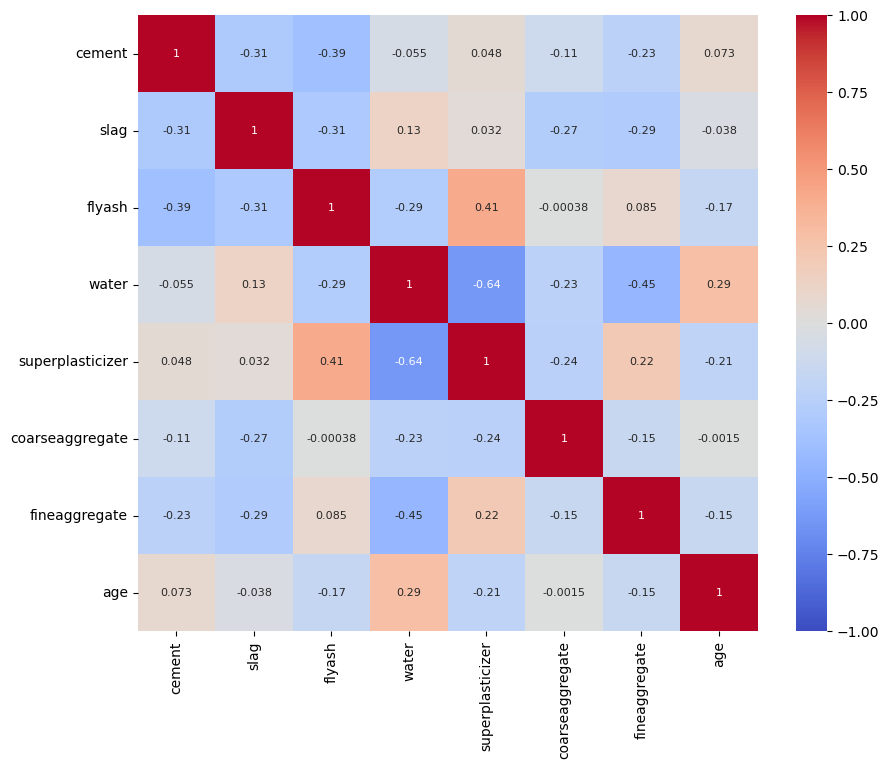

In [12]:
## Visualize the correlation between any two columns as heatmap.
# What do you see from the correlation heatmap? If several attributes have strong correlation, colinearity could be an issue for the regression analysis

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(X_train.corr(), # visualize the correlation matrix of X_train
            annot = True, # show correlation coefficients 
            annot_kws={'size':8}, # size of the correlation coefficients
            vmin=-1, vmax=1, # Values to anchor the colormap
            center= 0, # The value at which to center the colormap when plotting divergent data
            cmap= 'coolwarm', # color scheme of the heatmap
            ax=ax); #Axes in which to draw the plot, otherwise use the currently-active Axes.

### How many features to extract/select ?

Text(0, 0.5, 'ratio of cumulative variance explained')

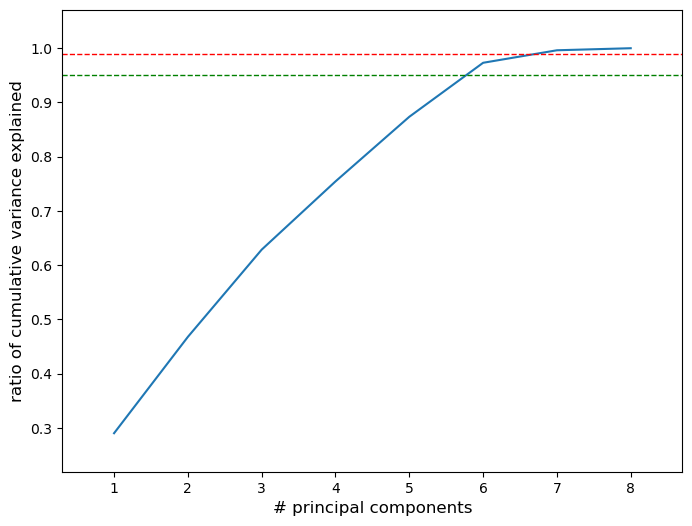

In [13]:
# PCA analysis

pca = PCA(n_components=8)
pca.fit(StandardScaler().fit_transform(X_train))

fig, ax = plt.subplots( figsize=(8,6))
ax.plot(range(1,9),np.cumsum(pca.explained_variance_ratio_))
ax.axhline(y = 0.99, c='r', linewidth =1, linestyle='--')
ax.axhline(y = 0.95, c='g', linewidth =1, linestyle='--' )
plt.margins(0.1)
ax.set_xlabel('# principal components',fontsize=12)
ax.set_ylabel('ratio of cumulative variance explained',fontsize=12)

#plt.savefig('PCA')
# six pincipal components have explained over 95% of data variance. We could use the top six components. But 6 and 8 are not a huge difference. 
## actually feature extraction is more important for high dimensional input data.

### Extract Features using PCA

In [14]:
# apply PCA to transform attribute data into their principal components
Fr_train=pca.transform(StandardScaler().fit_transform(X_train)) # transform the training data as PCs
Fr_test=pca.transform(StandardScaler().fit_transform(X_test)) # transform the testing data as PCs

### Exploratory Data Analysis of extracted PCs

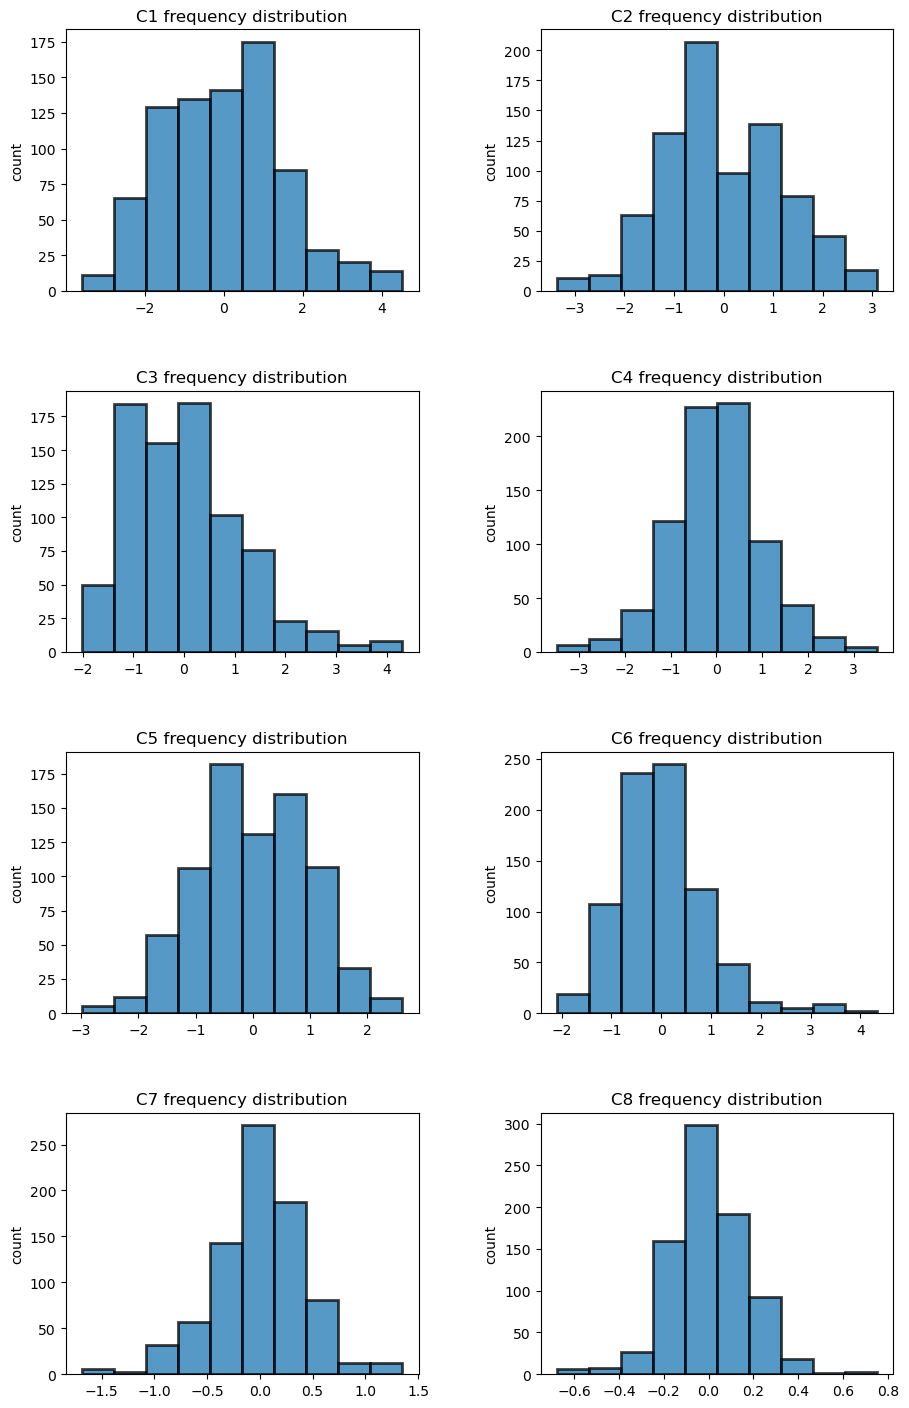

In [15]:
# frequency distributions of PC features
plt.figure(figsize=(10,15))
for i in range(0,N):
  plt.subplot(4,2,(i)+1)
  plt.hist(x=Fr_train[:,i],alpha=0.75,edgecolor='black',linewidth=2)
  plt.title('C'f'{i+1} frequency distribution',fontsize=12)
  plt.ylabel('count')
  plt.tight_layout(pad=4.0)
  plt.grid(False)
plt.show()

## Define metrics for evaluating goodness-of-fit

In [16]:
# assembly model overall goodness-of-fit metrics on training data
def print_selection(model, Fr, Y, M, N, rsp_type="numr"):
    # rsp_type: default value is "numr" - numerical response. "cgtr" - categorical response

    if rsp_type=="numr":
        LogL = (-M/2*np.log(2*np.pi)-M*np.log(np.sqrt(metrics.mean_squared_error(Y, model.predict(Fr))))-(M-N-1)/2)
        AIC = -2*LogL+2*(1+N)
        BIC = -2*LogL+np.log(M)*(1+N)
        r2_train = cross_val_score(model, Fr, Y, cv =5, scoring = 'r2').mean()
        adj_r2_train = 1 - (1 - r2_train) * ((M - 1) / (M - N - 1))
        print(f"AIC:{AIC:,.0f}")
        print(f"BIC:{BIC:,.0f}")
        print(f'The average R squared value for training: {r2_train*100 :.2f}%')
        print(f'The average adjusted R squared value for training: {adj_r2_train*100 :.2f}%')
    
    elif rsp_type=="cagr":
        acc_train = cross_val_score(model, Fr, Y, cv =5, scoring = 'accuracy').mean()
        print(f'The average accuracy for training: {acc_train*100 :.2f}%')
    
    else:
        print('wrong type: {numr: numerical, cagr: categorical} ')


In [83]:
# assembly model performance metrics together
def print_evaluate(true, predicted, rsp_type="numr"):
# rsp_type: default value is "numr" - numerical response. "cgtr" - categorical response
    from sklearn import metrics
    from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
    
    if rsp_type=="numr":
        mae = metrics.mean_absolute_error(true, predicted)
        mse = metrics.mean_squared_error(true, predicted)
        rmse = np.sqrt(mse)
        r_squared = metrics.r2_score(true, predicted)
        #return mae, mse, rmse, r2_square
        print(f'MAE: {mae:.2f}')
        print(f'MSE: {mse:.2f}')
        print(f'RMSE: {rmse:.2f}')
        print(f'R Squared: {r_squared*100:.2f}%')
        print('__________________________________')
        
    elif rsp_type=="cagr":
        cls_report = metrics.classification_report(true, predicted)
        acc = metrics.accuracy_score(true, predicted)
        print(f'classification accuracy: {acc*100:.2f}%')
        print(f'classification report:{cls_report}\n')

        class_names = np.unique(true).astype(str).tolist()
        fig, ax = plt.subplots(figsize=(5,3))
        tick_marks = np.arange(len(class_names))
        cm = confusion_matrix(true,predicted)
        sns.heatmap(pd.DataFrame(cm), 
                    annot=True, 
                    cmap="YlGnBu" ,
                    fmt='g',
                    xticklabels=class_names,
                    yticklabels=class_names)
    
        ax.xaxis.set_label_position("top")
    
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show();
    else:
        print('wrong type: "numr"-numerical, "cagr"-categorical')

## Linear Regression Model

### Ordinary Least Squares

In [18]:
# call the linear regressor and fit the linear regression model

lr_model = LinearRegression().fit(Fr_train,y_str_train)

In [19]:
# define coefficient names
Coef_names = [f"w{i}" for i in range(N+1)]
Coef_names

['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']

In [20]:
# regression coefficients, w0, w1,..., w8
coeff_df = pd.DataFrame(np.append(lr_model.intercept_,lr_model.coef_), 
                        index = Coef_names,
                        columns = ['Coefficient'])
coeff_df.round(3)

,Coefficient
w0,35.666
w1,-0.156
w2,-0.468
w3,7.375
w4,1.329
w5,-5.037
w6,7.749
w7,-7.370
w8,11.752


In [21]:
## We can also find regression coefficients using linear algebra
Z = np.append(np.ones([M,1]),Fr_train,1)  # eq.(9)
w_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ y_str_train  # eq.(16)
coef_lr = pd.DataFrame(w_hat,
                       index = Coef_names,
                       columns=['Coefficient'])
coef_lr.round(3)

,Coefficient
w0,35.666
w1,-0.156
w2,-0.468
w3,7.375
w4,1.329
w5,-5.037
w6,7.749
w7,-7.370
w8,11.752


In [22]:
# We can also provide the interval estimates for the coefficients 

# calculate standard errors of regression efficients using linear algebra
residuals = y_str_train - lr_model.predict(Fr_train)
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (M-N-1) # this is the point estimate of sigma_epsilon^2. see eq.(19)

var_w_hat =np.linalg.inv(Z.T @ Z)*sigma_squared_hat # eq.(21)

se = np.sqrt(np.diag(var_w_hat)) #eq.(22)

# determine the t-value
from scipy.stats import t
alpha = 0.05 # level of significance. You can change to your own value
t_val = t(M-N-1).ppf(1-alpha/2) # t-value at 1-alpha/2

# margin of error
me = se * t_val #eq.(23)

In [23]:
# display the (1-alpha) confidence interval estimates for regression coefficients w0, w1,..., w8
lr_coefficients_CI=pd.DataFrame(np.append(w_hat.reshape(N+1,1),me.reshape(N+1,1),1),
                                index = Coef_names,
                                columns=['Coefficient','Margin of error'])
print(f'the {1-alpha} interval estimates for the regression coefficients are:\n')
lr_coefficients_CI.round(3)

# the 95% interval estimates for w1 and w2 constains zero, indicating C1 and C2 might not be useful predictors 

the 0.95 interval estimates for the regression coefficients are:



,Coefficient,Margin of error
w0,35.666,0.722
w1,-0.156,0.474
w2,-0.468,0.605
w3,7.375,0.636
w4,1.329,0.719
w5,-5.037,0.739
w6,7.749,0.809
w7,-7.370,1.680
w8,11.752,4.150


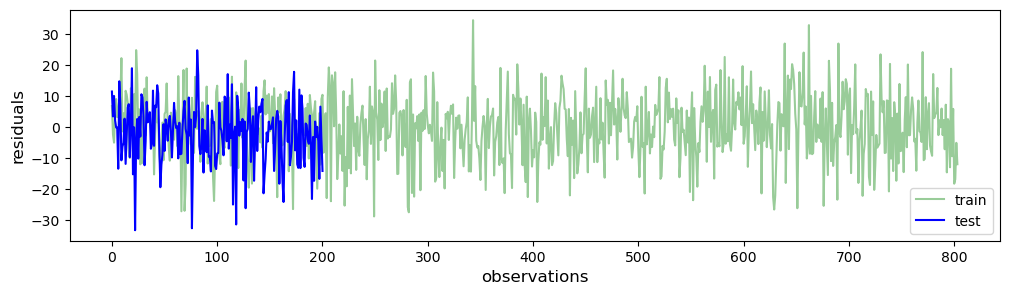

In [24]:
# visually check independence of residuals
# independence of residuals seems to hold

plt.figure(figsize=(12,3))
plt.plot(y_str_train-lr_model.predict(Fr_train),c='g',alpha=0.4) # residual calculated using the training dataset
plt.plot(y_str_test-lr_model.predict(Fr_test),c='b') # residual calculated using the testing dataset
plt.xlabel('observations',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.legend(['train','test'])
plt.show()

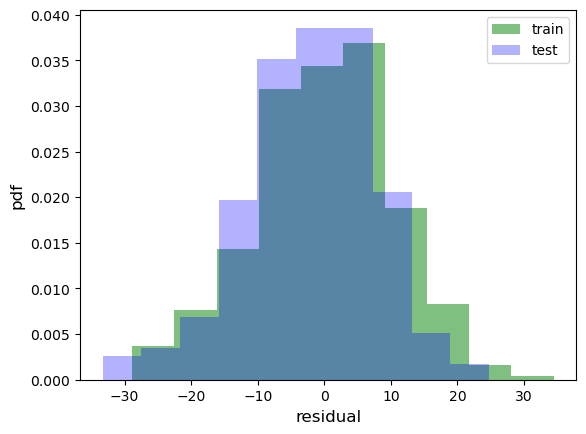

In [25]:
# examine the distribution of residuals
# the nomality of redisuals seems to hold

plt.hist(y_str_train-lr_model.predict(Fr_train),density=True,color='g',alpha=0.5) # distribution of residuals - training dataset
plt.hist(y_str_test-lr_model.predict(Fr_test),density=True,color='b',alpha=0.3) # distribuition of residuals - testing dataset
plt.legend(['train','test'])
plt.xlabel('residual',fontsize=12)
plt.ylabel('pdf',fontsize=12)
plt.show()

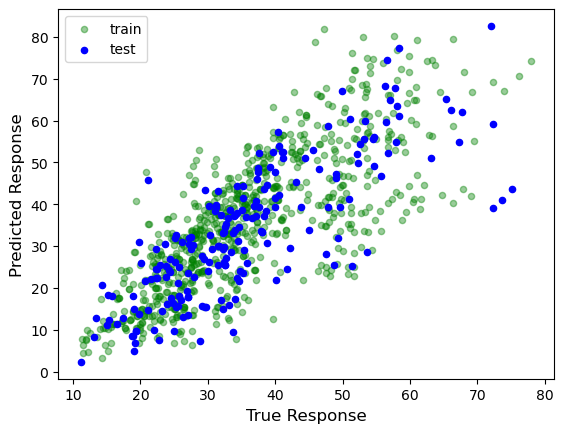

In [26]:
# show the correlation between predicted response and true response

plt.scatter(lr_model.predict(Fr_train),y_str_train,c='g',s=20,alpha=0.4) # true vs. prediction - training dataset
plt.scatter(lr_model.predict(Fr_test),y_str_test,c='b',s=20) # # true vs. prediction - testing dataset
plt.xlabel('True Response',fontsize=12)
plt.ylabel('Predicted Response',fontsize=12)
plt.legend(['train','test'])
plt.show()

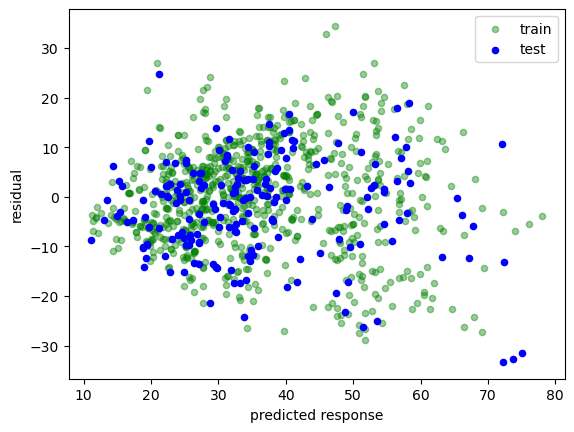

In [27]:
# residual against predicted response to check the homogeneity of residuals
plt.scatter(lr_model.predict(Fr_train), y_str_train-lr_model.predict(Fr_train),c='g',s=20,alpha=0.4)  # residual vs. prediction - training dataset
plt.scatter(lr_model.predict(Fr_test), y_str_test-lr_model.predict(Fr_test),c='b',s=20) # residual vs. prediction -testing dataset
plt.legend(['train','test'])
plt.xlabel('predicted response')
plt.ylabel('residual')
plt.show()

In [28]:
# overall goodness-of-fit in training 
print_selection(lr_model, Fr_train, y_str_train, M, N)

AIC:6,051
BIC:6,093
The average R squared value for training: 56.41%
The average adjusted R squared value for training: 55.97%


In [29]:
# evaluate the model performance on the testing dataset
print_evaluate(y_str_test, lr_model.predict(Fr_test))

MAE: 7.62
MSE: 99.14
RMSE: 9.96
R Squared: 61.57%
__________________________________


In [30]:
# Univariate feature selection works by selecting the best features based on univariate statistical tests. 
# It can be seen as a preprocessing step to an estimator.
# SelectBest (metric, k) selects features according to the k highest scores.
FeatureSelection = SelectKBest(f_regression, k=6)
Fr_train_sel=FeatureSelection.fit_transform(Fr_train, y_str_train) # selected features
Sel_Index=FeatureSelection.get_support() # Boolean index indicating the selection
#Sel_Index=[False, True, True, True, True, True,True,True] #mannually override the selection result
print('Selected features are:\n',Sel_Index,'\n')

Fr_train_sel=Fr_train[:,Sel_Index]

# selected features in test dataset
Fr_test_sel = Fr_test[:,Sel_Index]

n = np.sum(Sel_Index) # the number of attributes

# fit the model using selected features
lr_model_new = LinearRegression().fit(Fr_train_sel, y_str_train)


# evaluate the goodness-of-fit of the regression model in training 
print('\nThe model overall goodness-of-fit in training is:')
print_selection(lr_model_new, Fr_train_sel, y_str_train, M, n)


print('\nThe test accuracy is:')
print_evaluate(y_str_test, lr_model_new.predict(Fr_test_sel))

Selected features are:
 [False False  True  True  True  True  True  True] 


The model overall goodness-of-fit in training is:
AIC:6,052
BIC:6,085
The average R squared value for training: 57.25%
The average adjusted R squared value for training: 56.92%

The test accuracy is:
MAE: 7.70
MSE: 100.99
RMSE: 10.05
R Squared: 60.85%
__________________________________


### Laccos

In [31]:
# fit a Lasso regression model
lassor_model = Lasso(alpha=0.5).fit(Fr_train,y_str_train)

In [32]:
# regression coefficents
coeff_lassor = pd.DataFrame(np.append(lassor_model.intercept_,lassor_model.coef_),
                            index = Coef_names,
                            columns = ['Coefficient'])
coeff_lassor.round(3)

,Coefficient
w0,35.666
w1,-0.000
w2,-0.116
w3,6.986
w4,0.832
w5,-4.513
w6,7.121
w7,-4.661
w8,0.000


In [33]:
#evaluate the goodness-of-fit of the regression model in training 
print('\nThe model overall goodness-of-fit in training is:')
print_selection(lassor_model, Fr_train, y_str_train, M, N)

# evaluate the model on the test dataset
print('\nThe test accuracy is:')
print_evaluate(y_str_test, lassor_model.predict(Fr_test))


The model overall goodness-of-fit in training is:
AIC:6,100
BIC:6,142
The average R squared value for training: 54.55%
The average adjusted R squared value for training: 54.09%

The test accuracy is:
MAE: 7.95
MSE: 102.56
RMSE: 10.13
R Squared: 60.24%
__________________________________


### Ridge

In [34]:
# fit a Ridge regression model
Ridge_model = Ridge(alpha=0.5).fit(Fr_train,y_str_train)


In [35]:
# regression coefficents
coeff_Ridge = pd.DataFrame(np.append(Ridge_model.intercept_,Ridge_model.coef_), 
                           index = Coef_names,
                           columns=['Coefficient'])
coeff_Ridge.round(3)

,Coefficient
w0,35.666
w1,-0.156
w2,-0.468
w3,7.371
w4,1.328
w5,-5.034
w6,7.742
w7,-7.345
w8,11.515


In [36]:
#evaluate the goodness-of-fit of the regression model in training 
print('\nThe model overall goodness-of-fit in training is:')
print_selection(Ridge_model, Fr_train, y_str_train, M, N)

# evaluate the model on the test dataset
print('\nThe test accuracy is:')
print_evaluate(y_str_test, Ridge_model.predict(Fr_test))


The model overall goodness-of-fit in training is:
AIC:6,051
BIC:6,093
The average R squared value for training: 56.42%
The average adjusted R squared value for training: 55.98%

The test accuracy is:
MAE: 7.62
MSE: 99.09
RMSE: 9.95
R Squared: 61.59%
__________________________________


### Elastic Net

In [37]:
# fit Elastic Net regression that combines both L1 and L2 regulations on
# regression coefficients

#For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1
# penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2

ElasticNet_model = ElasticNet(alpha=0.06,l1_ratio=1).fit(Fr_train,y_str_train)

In [38]:
# regression coefficents
coeff_enr = pd.DataFrame(np.append(ElasticNet_model.intercept_,ElasticNet_model.coef_), 
                         index = Coef_names, 
                         columns=['Coefficient'])
coeff_enr.round(3)

,Coefficient
w0,35.666
w1,-0.130
w2,-0.426
w3,7.328
w4,1.269
w5,-4.974
w6,7.673
w7,-7.045
w8,9.769


In [39]:
#evaluate the goodness-of-fit of the regression model in training 
print('\nThe model overall goodness-of-fit in training is:')
print_selection(ElasticNet_model, Fr_train, y_str_train, M, N)

# evaluate the model on the test dataset
print('\nThe test accuracy is:')
print_evaluate(y_str_test, ElasticNet_model.predict(Fr_test))


The model overall goodness-of-fit in training is:
AIC:6,052
BIC:6,094
The average R squared value for training: 56.45%
The average adjusted R squared value for training: 56.01%

The test accuracy is:
MAE: 7.64
MSE: 98.78
RMSE: 9.94
R Squared: 61.71%
__________________________________


### Fine tuning Hyperparameters of Elastic Net Regression

In [40]:
# fit Elastic Net regression that combines both L1 and L2 regulations on regression coefficients

# This parameter can be a list, in which case the different values are tested by
# cross-validation and the one giving the best prediction score is used.

# Note that a good choice of list of values for l1_ratio is often to put more values
# close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge), as in
 # [.1, .5, .7, .9, .95, .99, 0.995, 1].
l1_ratios = [.1, .5, .7, .9, .95, .99, .995, 0.999, 1]

# we either choose a list of alpha or define the number of alphas for each l1 reatio
#alphas = np.arange(0,10.,0.1)

encvr_model = ElasticNetCV(l1_ratio=l1_ratios,
                           cv=5,
                           random_state=5,
                           n_alphas=100
                          ).fit(Fr_train,y_str_train)
print('The selected alpha is', f'{encvr_model.alpha_:.3}','\n')
print('The selected l1 ratio is', f'{encvr_model.l1_ratio_:.3}','\n')

The selected alpha is 0.0582 

The selected l1 ratio is 1.0 



In [41]:
# regression coefficents
coeff_encvr = pd.DataFrame(np.append(encvr_model.intercept_,encvr_model.coef_), 
                           index = Coef_names, 
                           columns=['Coefficient'])
coeff_encvr.round(3)

,Coefficient
w0,35.666
w1,-0.131
w2,-0.427
w3,7.330
w4,1.271
w5,-4.976
w6,7.675
w7,-7.054
w8,9.827


In [42]:
#evaluate the goodness-of-fit of the regression model in training 
print('\nThe model overall goodness-of-fit in training is:')
print_selection(encvr_model, Fr_train, y_str_train, M, N)

# evaluate the model on the test dataset
print('\nThe test accuracy is:')
print_evaluate(y_str_test, encvr_model.predict(Fr_test))


The model overall goodness-of-fit in training is:
AIC:6,052
BIC:6,094
The average R squared value for training: 56.32%
The average adjusted R squared value for training: 55.88%

The test accuracy is:
MAE: 7.64
MSE: 98.79
RMSE: 9.94
R Squared: 61.70%
__________________________________


## Polynomial Linear Model

### Generate polynomial features from predictor variables

In [43]:
# generate polynomial features
poly_degree = 3
poly_reg = PolynomialFeatures(degree=poly_degree) # if a, b and c are three features, ab, ac, and bc are degree-2 polynomial features. a^2b, a^2c, b^2a, b^2c, c^2a, c^2b, a^3, b^3, c^3 are 3-degree polynomial features
X_poly_train= poly_reg.fit_transform(Fr_train) # transform features into those with polynomial features
X_poly_test=poly_reg.fit_transform(Fr_test)

### Fine tune Elastic Net

In [44]:
l1_ratios = [.1, .5, .7, .9, .95, .99, .995, 0.999, 1]

#plr=ElasticNetCV(l1_ratio=l1_ratios,cv=5,random_state=5,n_alphas=100, max_iter=1000, tol=0.01, fit_intercept=False)
plr_model=ElasticNetCV(l1_ratio=l1_ratios,
                       cv=5,
                       random_state=5,
                       n_alphas=100, 
                       max_iter=1000, 
                       tol=0.01, 
                       fit_intercept=False
                      ).fit(X_poly_train,y_str_train)

print('The selected alpha is', f'{plr_model.alpha_:.3}','\n')
print('The selected l1 ratio is', f'{plr_model.l1_ratio_:.3}','\n')
## result of fine tuning suggests the best model is Laccos regression, that is linear regression with norm-1 regularization

## If we remove the regulilarizers, we just use the ordinary linear regrsesion model
#plr_model=LinearRegression().fit(X_poly_train,y_st_train)

The selected alpha is 0.0916 

The selected l1 ratio is 1.0 



In [45]:
# regression coefficents
coeff_plr = pd.DataFrame(plr_model.coef_, poly_reg.get_feature_names_out(), columns=['Coefficient'])
coeff_plr.round(4)


,Coefficient
1,42.0934
x0,0.7966
x1,-1.3092
x2,4.9174
x3,-1.2546
...,...
x5 x7^2,0.0000
x6^3,-0.0000
x6^2 x7,0.0000
x6 x7^2,0.0000


In [46]:
# count the number of regression coefficients that are estimated as zero
print('The number of polynomial attributes dropped is:',np.sum([coeff_plr==0]))


The number of polynomial attributes dropped is: 70


In [47]:
# number of predictors
n = np.sum([coeff_plr!=0])-1

# mse
sigma_squared_hat  = (y_str_train - plr_model.predict(X_poly_train)).T @ (y_str_train - plr_model.predict(X_poly_train))/(M-n-1)
# estimation of the standard deviation's residuals
var_w_hat_poly =np.linalg.inv(X_poly_train.T @ X_poly_train)*sigma_squared_hat

# t-value
from scipy.stats import t
alpha = 0.05 # level of significance. You can change to your own value
t_val = t(M-n-1).ppf(1-alpha/2) # t-value at 1-alpha/2

# margin of error
me_poly=np.sqrt(np.diag(var_w_hat_poly))*t_val

# Boolean index that indentifies selelected polynomial terms
Sel_Index = coeff_plr['Coefficient'] != 0

# display the (1-alpha) confidence interval estimates for regression coefficients w0, w1,..., w8
polycoefficients_CI=pd.DataFrame(np.append(coeff_plr[Sel_Index],me_poly[Sel_Index].reshape(n+1,1),1),
                                columns=['Coefficients','Margin of error'])
print(f'the {1-alpha} confidence interval for the regression coefficients are:\n')
polycoefficients_CI.round(3)

the 0.95 confidence interval for the regression coefficients are:



,Coefficients,Margin of error
0,42.093,4.402
1,0.797,3.043
2,-1.309,2.757
3,4.917,3.332
4,-1.255,3.297
...,...,...
90,-0.682,0.986
91,-0.377,1.598
92,0.360,8.625
93,0.099,1.574


In [48]:
#evaluate the goodness-of-fit of the regression model in training 
print('\nThe model overall goodness-of-fit in training is:')
print_selection(plr_model, X_poly_train, y_str_train, M, n)

# evaluate the model on the test dataset
print('\nThe test accuracy is:')
print_evaluate(y_str_test, plr_model.predict(X_poly_test))


The model overall goodness-of-fit in training is:
AIC:5,245
BIC:5,690
The average R squared value for training: 77.86%
The average adjusted R squared value for training: 74.92%

The test accuracy is:
MAE: 4.94
MSE: 39.57
RMSE: 6.29
R Squared: 84.66%
__________________________________


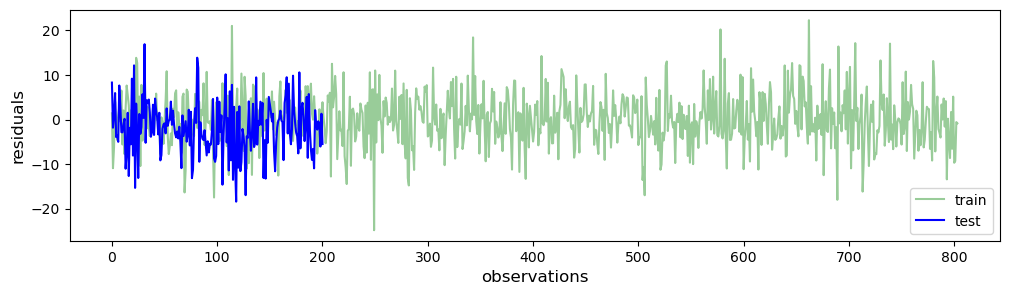

In [49]:
# visually check independence of residuals
plt.figure(figsize=(12,3))
plt.plot(y_str_train-plr_model.predict(X_poly_train),c='g',alpha=0.4) # residual calculated using the training dataset
plt.plot(y_str_test-plr_model.predict(X_poly_test),c='b') # residual calculated using the testing dataset
plt.xlabel('observations',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.legend(['train','test'])
plt.show()

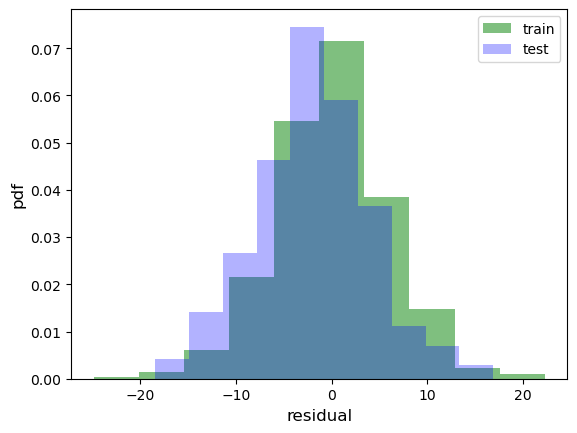

In [50]:
# examine the distribution of residuals
plt.hist(y_str_train-plr_model.predict(X_poly_train),density=True,color='g',alpha=0.5) # distribution of residuals - training dataset
plt.hist(y_str_test-plr_model.predict(X_poly_test),density=True,color='b',alpha=0.3) # distribuition of residuals - testing dataset
plt.legend(['train','test'])
plt.xlabel('residual',fontsize=12)
plt.ylabel('pdf',fontsize=12)
plt.show()

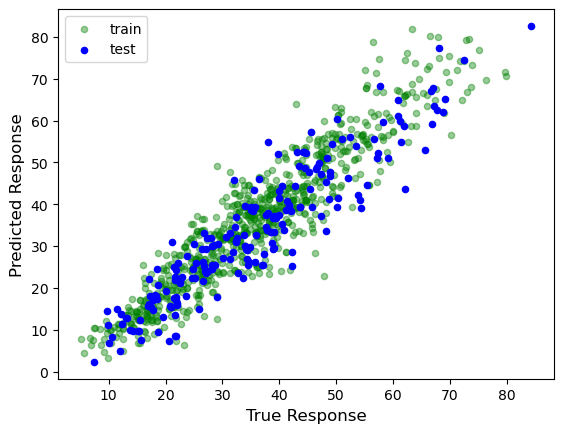

In [51]:
# show the correlation between predicted response and true response
plt.scatter(plr_model.predict(X_poly_train),y_str_train,c='g',s=20,alpha=0.4) # true vs. prediction - training dataset
plt.scatter(plr_model.predict(X_poly_test),y_str_test,c='b',s=20) # # true vs. prediction - testing dataset
plt.xlabel('True Response',fontsize=12)
plt.ylabel('Predicted Response',fontsize=12)
plt.legend(['train','test'])
plt.show()

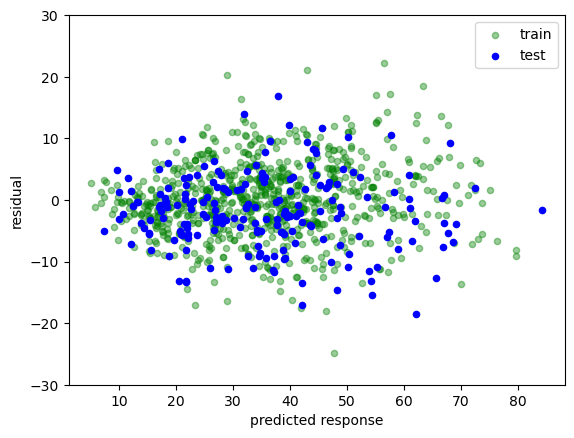

In [52]:
# residual against predicted response to check the homogeneity of residuals
plt.scatter(plr_model.predict(X_poly_train), y_str_train-plr_model.predict(X_poly_train),c='g',s=20,alpha=0.4)  # residual vs. prediction - training dataset
plt.scatter(plr_model.predict(X_poly_test), y_str_test-plr_model.predict(X_poly_test),c='b',s=20) # residual vs. prediction -testing dataset
plt.ylim([-30,30])
plt.legend(['train','test'])
plt.xlabel('predicted response')
plt.ylabel('residual')
plt.show()

## Binary Logistic Regression

We fit a binary logistic regression to predict if a concrete block will develop defect after one year of use by using the extracted PCs as the predictors

In [53]:
# let's check if classes are unbalanced. If it is unbalanced, we may consider
# using class weights in defining the loss function
uniqueVals, counts = np.unique(y_dft_train,return_counts=True)
print(f'The sizes for the classes {uniqueVals} are:{counts}\n')
print(counts)

The sizes for the classes [0. 1.] are:[575 229]

[575 229]


In [54]:
# fit a logistic regression model
blr_model=LogisticRegression(
    class_weight={0:1,1:1.5},
    solver='sag'
).fit(Fr_train,y_dft_train) # if use cross-entropy loss, multi-class='multinomial'


In [55]:
# regression coefficients
coeff_blr = pd.DataFrame(np.append(blr_model.intercept_,blr_model.coef_), 
                         index = Coef_names, 
                         columns = ['Coefficient'])
coeff_blr.round(3)

,Coefficient
w0,-3.253
w1,-1.644
w2,0.924
w3,-1.609
w4,2.284
w5,2.062
w6,-5.268
w7,1.082
w8,-2.021


In [56]:
# training accuracy
print_selection(blr_model, Fr_train, y_dft_train, M, N,"cagr")

The average accuracy for training: 88.55%


classification accuracy: 89.55%
classification report:              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       136
         1.0       0.81      0.88      0.84        65

    accuracy                           0.90       201
   macro avg       0.88      0.89      0.88       201
weighted avg       0.90      0.90      0.90       201




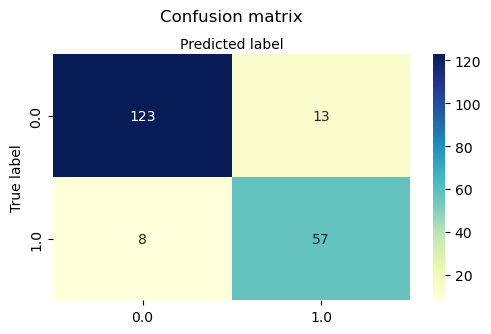

In [84]:
# regression model test performance 
print_evaluate(y_dft_test,blr_model.predict(Fr_test),"cagr")

In [58]:
# prediction on testing dataset
y_test_pred = blr_model.predict(Fr_test) #prediction of y_i's
p_test_pred = blr_model.predict_proba(Fr_test) # the probabilities that y_i is classes 0 and 1, respectively

## Multinomial Logistic Regression

In [59]:
digits = datasets.load_digits() #load data
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

In [85]:
X, y = digits.data, digits.target #digits.data are predictors, digits.target is the response with 10 class (0,1,...,9)

# Parameters
n_prd = X.shape[1] # number of observations
print('The number of predictors is:', n_prd,'\n')
n_classes = len(np.unique(y)) # number of classes
print('The number of classes is:',n_classes,'\n')
obs = len(y)
print('The number of data points is:',obs, '\n')

random_state = 4 # to make the result replicable


X_norm = StandardScaler().fit_transform(X) # data normalization

# Split data (both features X and target y) into training and testing datasets.
# We use training data to learn model parameters.
# We use test data to assess the performance of prediction
X_train, X_test, y_train, y_test = train_test_split(
                                                    X_norm, y, test_size=0.2, stratify=y,
                                                    random_state=random_state)


The number of predictors is: 64 

The number of classes is: 10 

The number of data points is: 1797 



In [86]:
# fit a multnomial logistic regression
mlr=LogisticRegression(solver='saga',
                       penalty='elasticnet', 
                       l1_ratio=0.3, 
                       max_iter=2000)
mlr_model = mlr.fit(X_train,y_train)

In [87]:
# point estimates of regression coefficients
coeff_mlr = pd.DataFrame(np.insert(mlr_model.coef_.T,0,mlr_model.intercept_,axis=0)) #insert mlr_model.intercept_before row 0
#coeff_mlr = pd.DataFrame(np.append(mlr_model.intercept_,mlr_model.coef_), columns=['Coefficient'])
print('regression coefficients are:\n')
print(coeff_mlr.round(4))

print('The number of zero-valued coefficients is:', (n_prd+1)*n_classes-np.count_nonzero(coeff_mlr))

regression coefficients are:

         0       1       2       3       4       5       6       7       8  \
0  -0.1868 -0.5012 -0.2592  0.0604 -0.3242  0.2925 -0.3073  0.0364  1.4100   
1   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2   0.0000  0.0000  0.0000  0.1271 -0.0943  0.2940  0.0000  0.0000 -0.1060   
3   0.0000  0.0000  0.0513 -0.1785 -0.4188  1.0682 -0.2932  0.2390  0.0584   
4   0.0000  0.2084  0.0520  0.0573 -0.9209 -0.2401 -0.1408  0.0615 -0.1538   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
60  0.1798 -0.1211  0.2106  0.1194 -0.5497  0.6817 -0.2939 -0.4763  0.1814   
61  0.0000  0.3228  0.0316  0.0000 -0.3684 -0.0082  0.0000 -0.8747  0.4903   
62 -0.0733  0.6608  0.6555  0.0000 -0.5185  0.0000  0.6583 -0.8237 -0.2678   
63 -0.0574  0.3087  0.6573  0.0218 -0.0548 -0.6664  0.0478 -0.1176 -0.1525   
64  0.0000  0.4124  0.3947 -0.1550  0.0000 -0.0386 -0.0837  0.0000  0.0000   

         9  
0  -0.2206  
1   0.0

In [63]:
# training accuracy
print_selection(mlr_model, X_train, y_train, M, N,"cagr")

The average accuracy for training: 96.66%


classification accuracy: 98.06%
classification report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      0.97      0.95        37
           2       0.97      1.00      0.99        35
           3       1.00      0.97      0.99        37
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        36
           6       1.00      0.94      0.97        36
           7       0.97      1.00      0.99        36
           8       0.94      0.91      0.93        35
           9       1.00      1.00      1.00        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360




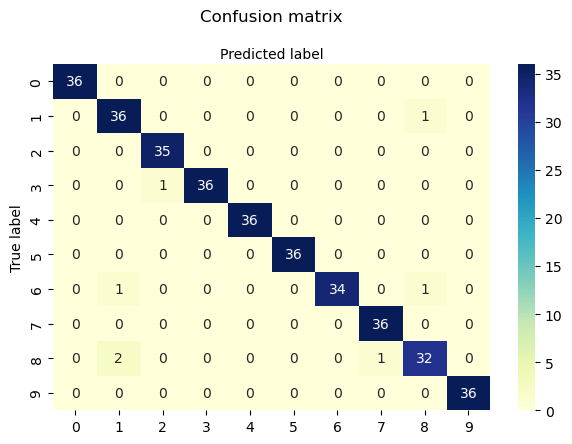

In [64]:
# regression model test performance 
print_evaluate(y_test,mlr_model.predict(X_test),"cagr")

## Ordinal Logistic Regression

### Diamonds dataset


The Diamond.csv dataset we use here is a revision of the dataset diamonds.csv from Kaggle. It contains the prices and other attributes of almost 54,000 diamonds.

Attributes
carat: weight of the diamond (0.2--5.01)

cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: diamond colour, from J (worst) to D (best)

clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table: width of top of diamond relative to widest point (43--95)

price: price in US dollars (\$326--\$18,823)

volume: x*y*z mm^3 (0--20116.23)

In [67]:
#Load data
Diamond = pd.read_csv('Data/Diamond.csv')
Diamond.head()

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,38.20
1,0.21,Premium,E,SI1,59.8,61.0,326,34.51
2,0.23,Good,E,VS1,56.9,65.0,327,38.08
3,0.29,Premium,I,VS2,62.4,58.0,334,46.72
4,0.31,Good,J,SI2,63.3,58.0,335,51.92


In [68]:
# Check the data type of the dataset
Diamond.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   volume   53940 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.3+ MB


In [69]:
# statsmodels requires that the response is a categorical variable with ordered classes.
# Therefore, we define the response as an ordered categorical variable
cat_type = pd.CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)
Diamond['cut'] = Diamond['cut'].astype(cat_type)
Diamond['cut'].dtype

CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True, categories_dtype=object)

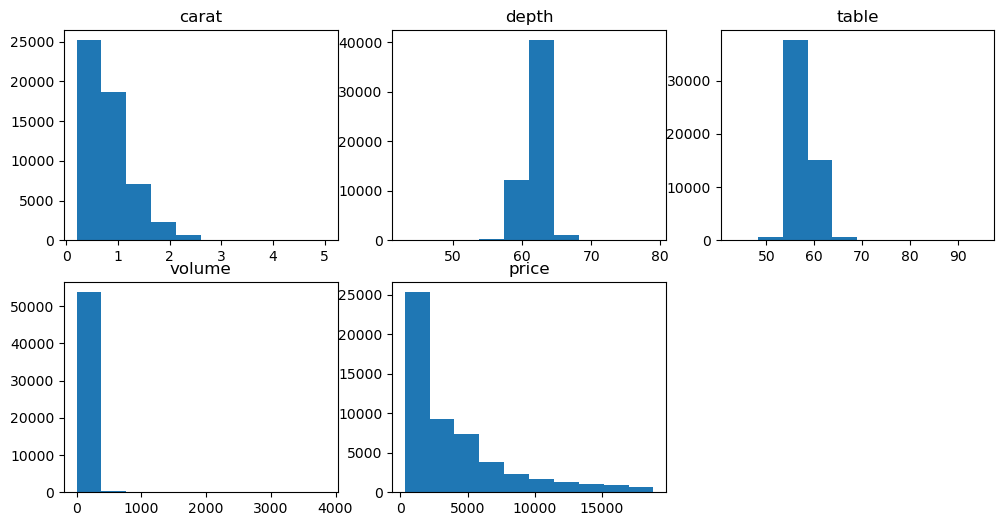

In [70]:
# show the histogram of numerical predictors
# several of them are not normally distributed and their scales are quite different.
# we may normalize these predicdtors

plt.figure(figsize=(12, 6))

plt.subplot(2,3,1)
plt.hist(Diamond.carat)
plt.title('carat')

plt.subplot(2,3,2)
plt.hist(Diamond.depth)
plt.title('depth')

plt.subplot(2,3,3)
plt.hist(Diamond.table)
plt.title('table')

plt.subplot(2,3,4)
plt.hist(Diamond.volume)
plt.title('volume')

plt.subplot(2,3,5)
plt.hist(Diamond.price)
plt.title('price')

plt.show()

In [71]:
# show the frequency distributions of categorical predictors and the response as well
# If categorical variables are used as predictors, we may recode them as dummy variables
print(Diamond[['cut']].value_counts(),'\n')
print(Diamond[['color']].value_counts(),'\n')
print(Diamond[['clarity']].value_counts())

cut      
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64 

color
G        11292
E         9797
F         9542
H         8304
D         6775
I         5422
J         2808
Name: count, dtype: int64 

clarity
SI1        13065
VS2        12258
SI2         9194
VS1         8171
VVS2        5066
VVS1        3655
IF          1790
I1           741
Name: count, dtype: int64


In [72]:
# normalize the quantitative predictors
temp=StandardScaler().fit_transform(Diamond[['carat','depth','table','price','volume']])
Diamond=pd.concat([pd.DataFrame(temp,columns=['carat','depth','table','price','volume']),Diamond[['cut','color','clarity']]],axis=1)
Diamond.head()

,carat,depth,table,price,volume,cut,color,clarity
0,-1.198168,-0.174092,-1.099672,-0.904095,-1.171321,Ideal,E,SI2
1,-1.240361,-1.360738,1.585529,-0.904095,-1.218480,Premium,E,SI1
2,-1.198168,-3.385019,3.375663,-0.903844,-1.172854,Good,E,VS1
3,-1.071587,0.454133,0.242928,-0.902090,-1.062431,Premium,I,VS2
4,-1.029394,1.082358,0.242928,-0.901839,-0.995973,Good,J,SI2


In [73]:
# code categorical predictors as dummy variables
Diamond = pd.get_dummies(Diamond, columns=['color','clarity'],dtype=float)
Diamond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   carat         53940 non-null  float64 
 1   depth         53940 non-null  float64 
 2   table         53940 non-null  float64 
 3   price         53940 non-null  float64 
 4   volume        53940 non-null  float64 
 5   cut           53940 non-null  category
 6   color_D       53940 non-null  float64 
 7   color_E       53940 non-null  float64 
 8   color_F       53940 non-null  float64 
 9   color_G       53940 non-null  float64 
 10  color_H       53940 non-null  float64 
 11  color_I       53940 non-null  float64 
 12  color_J       53940 non-null  float64 
 13  clarity_I1    53940 non-null  float64 
 14  clarity_IF    53940 non-null  float64 
 15  clarity_SI1   53940 non-null  float64 
 16  clarity_SI2   53940 non-null  float64 
 17  clarity_VS1   53940 non-null  float64 
 18  clarit

### Fitting an Ordinal Logistic Regression Model

In [74]:
# our hypothesis is that the cut can be inferred from the physical features of
# diamonds, including carat, table, depth, and volume
X =Diamond[['carat','table','depth','volume']]
y = Diamond['cut']
random_state = 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state)

In [75]:
# statsmodels requires that the response is an ordered categorical variable
# we change the response in the training dataset accordingly
#cat_type = pd.CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)
#y_train = y_train.astype(cat_type)
#y_train.dtype

In [76]:
ordlr_model = OrderedModel(y_train,X_train,distr='logit')
result_ordlr = ordlr_model.fit(method='bfgs')
result_ordlr.summary()

Optimization terminated successfully.
         Current function value: 1.167117
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                    cut   Log-Likelihood:                -50363.
Model:                   OrderedModel   AIC:                         1.007e+05
Method:            Maximum Likelihood   BIC:                         1.008e+05
Date:                Mon, 22 Sep 2025                                         
Time:                        20:24:51                                         
No. Observations:               43152                                         
Df Residuals:                   43144                                         
Df Model:                           4                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
carat                -0.4007      0.114     -3.513      0.000      -0.624      -0.177
table                -1.3351      0.012   -111.965      0.000      -1.358      -1.312
depth                -0.8960      0.012    -75.184      0.000      -0.919      -0.873
volume                0.3414      0.116      2.935      0.003       0.113       0.569
Fair/Good            -4.4689      0.033   -133.768      0.000      -4.534      -4.403
Good/Very Good        0.6294      0.016     39.705      0.000       0.598       0.660
Very Good/Premium     0.5170      0.010     53.887      0.000       0.498       0.536
Premium/Ideal         0.3441      0.009     39.562      0.000       0.327       0.361
=====================================================================================
"""

In [77]:
# the estimates of p_{i,k} = p(y_i=class k|x_i, hat_w, beta_k)
p = result_ordlr.model.predict(result_ordlr.params, X_test)
p

array([[0.02256752, 0.10845957, 0.31546436, 0.32129112, 0.23221743],
       [0.00650932, 0.0345237 , 0.14523742, 0.29780019, 0.51592936],
       [0.00296401, 0.01608078, 0.07504571, 0.20450542, 0.70140409],
       ...,
       [0.1421426 , 0.37757279, 0.33298674, 0.10685738, 0.04044049],
       [0.03204848, 0.14573715, 0.35855723, 0.28948147, 0.17417567],
       [0.01329658, 0.06759066, 0.23921504, 0.33857102, 0.3413267 ]])

In [78]:
# the estimates of y_i = argmax_k (y_{i,1},..., y_{i,k},..., y_{i,K})
# that is the class with the higheset probability is the prediction for y_i
y_test_pred=p.argmax(1)
y_test_pred

array([3, 4, 4, ..., 1, 2, 4])

In [79]:
# We convert the ordered categories of the ground truth into numbers
# In this way, the ground truth y_test and the prediction y_test_pred are in the same data type
# This makes the following evaluation easier
mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
y_test_num = np.vectorize(mapping.get)(y_test)

In [80]:
# Let's take a look at the counts by class in y_test and y_test_pred
class_names=['Fair', 'Good', 'Very Good', 'Premium','Ideal']

unique_values, counts = np.unique(y_test_num, return_counts=True)
print(f'The true volumes of class {class_names} are')
print(counts,'\n')

unique_values, counts = np.unique(y_test_pred, return_counts=True)
print(f'The predicted volumes of class {class_names} are')
print(counts)

The true volumes of class ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] are
[ 322  981 2417 2758 4310] 

The predicted volumes of class ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] are
[  95  390 2543 1409 6351]


### Evaluation

In [81]:
# calcualte accuracy
acc = np.sum(y_test_num==y_test_pred)/len(y_test_num)
acc.round(2)

np.float64(0.53)

<Figure size 640x480 with 0 Axes>

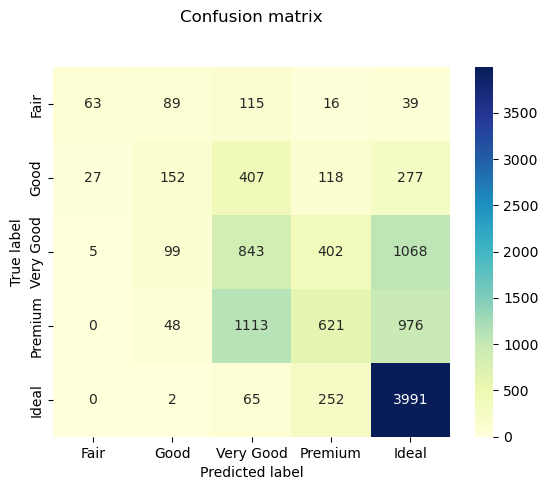

In [82]:
# confusion matrix
cnf_matrix=metrics.confusion_matrix(y_test_num, y_test_pred)

# visualize confusion matrix
plt.tight_layout()
fig, ax = plt.subplots()
class_names=['Fair', 'Good', 'Very Good', 'Premium','Ideal'] # name  of classes
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',ax=ax,xticklabels=class_names, yticklabels=class_names)
tick_marks = np.arange(len(class_names))
ax.xaxis.set_label_position("bottom")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()